# ASSIGNMENT DATA SCIENCE
## Problem statement
Our road networks are equipped with various sensors that measure traffic. ANPR (Automatic Number Plate Recognition) cameras monitor the road and use character recognition algorithms to detect and read license plates of vehicles. Inductive counting loops on the other hand are placed under the road surface and can detect vehicles passing over them.

In this particular case, the ANPR camera **CPT-C-0002.1** and the inductive counting loop **01A** are located on the same road segment close to each other. This means that we expect these two sensors to produce identical information about the traffic they observe.

The goal of this exercise is to make an analysis in order to demonstrate that (1) the two sensors work fine, or (2) one sensor is working properly and the other not, or (3) both sensors produce erroneous results. The analysis should be focused on the vehicle counts provided by the two sensors, but speed information is also provided and can be used. 

Make use of Python, its libraries and this Jupyter notebook to help you out and visualise your findings. The Jupyter notebook will be used to discuss your analysis, used logic and conclusions with members of the data science team. Every additional bit of useful information about the data is welcome and can be discussed.

We wish you the best of luck! If you have any questions, please use the following email address: bruno.cornelis@macq.eu


## Structure of the data
### Counting loop (*pboc_data_rv.csv*)

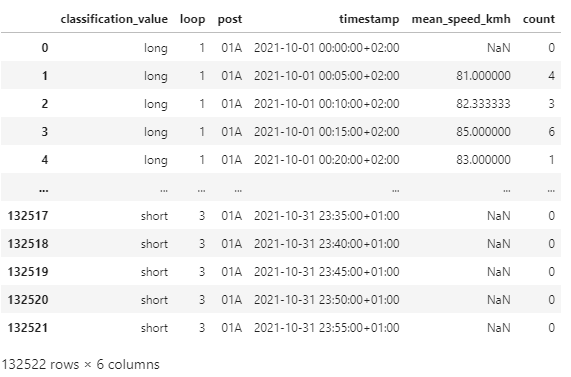

In [1]:
from PIL import Image
Image.open('./images/img_data_pboc_rv.png')

**Features**:
- **classification_value**: classification of the detected vehicle. "short", "medium", "long" represent the length of the vehicle.
- **loop**: id of the loop placed on a single lane of the road. There is one loop on each lane of the road.
- **post**: unique id of the counting post containing the different loops.
- **timestamp**: time of the observation. *Important:* The data is aggregated every 5 minutes.
- **mean_speed_kmh**: average speed of the vehicles detected in km/h.
- **count**: count of the vehicles.

**Explanation for the second row of the Data Frame**:  
There are 4 long vehicles detected by loop 1 of post 01A between 00:05 and 00:10. The average speed of those 4 vehicles equals 81 km/h.  

### ANPR camera (*pfic_data_rv.csv*)

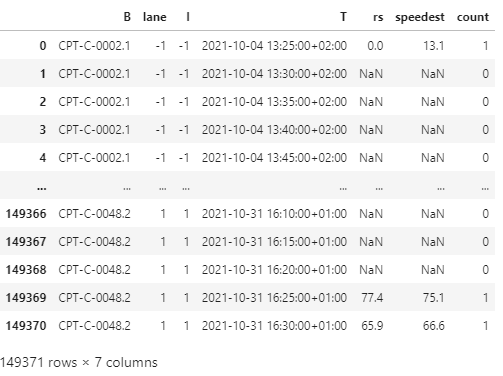

In [2]:
Image.open('./images/img_data_pfic_rv.png')

**Features**:
- **B**: unique ID of a camera
- **lane**: id of the lane observed by the camera (-1:unknown, 1:lane1, 2:lane2). *Be careful:* this camera does not observe traffic on the fastest lane. We don't know if 1 or 2 is the lane in the middle. 
- **l**: classification of the vehicle made by the camera (-1:unknown, 0:short vehicle, 1:long vehicle).
- **T**: time of the observation. The data is aggregated every 5 minutes.
- **rs**: average speed returned by the radar fixed to the camera in km/h.
- **speedest**: speed estimation from the camera in km/h.
- **count**: count of the vehicles.

**Explanation of the last row of the Data Frame**:  
There is 1 long vehicle detected by camera CPT-C-0048.2 on lane 1 between 16:30 and 16:35. The average speed is 65.9 km/h from the radar and 66.6 from the camera 

# Implementation :

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

counting_loop_df = pd.read_csv('pboc_data_rv.csv')
anpr_df = pd.read_csv('pfic_data_rv.csv')

In [4]:
# reformat timestamps
time_format='%Y-%m-%d %H:%M:%S'
anpr_df['T'] = pd.to_datetime(anpr_df['T'].apply(lambda x: x[:-6]), format=time_format)
anpr_df = anpr_df.rename({'T':'timestamp'}, axis='columns')
counting_loop_df['timestamp'] = pd.to_datetime(counting_loop_df['timestamp'].apply(lambda x: x[:-6]), format=time_format)

print(anpr_df.dtypes)
print(counting_loop_df.dtypes)

# set timestamps as index
# anpr_df = anpr_df.rename({'T':'timestamp'}, axis='columns').set_index('timestamp')
# counting_loop_df = counting_loop_df.set_index('timestamp')

B                    object
lane                  int64
l                     int64
timestamp    datetime64[ns]
rs                  float64
speedest            float64
count                 int64
dtype: object
classification_value            object
loop                             int64
post                            object
timestamp               datetime64[ns]
mean_speed_kmh                 float64
count                            int64
dtype: object


### Counting Loop

In [5]:
# check NaN values in counting_loop_df

na_count = [(column,counting_loop_df[column].isna().sum()) for column in counting_loop_df.columns]

na_count0 = [(column,counting_loop_df[counting_loop_df['count']==0][column].isna().sum()) for column in counting_loop_df.columns]

print(na_count)

print(na_count0)

# NaN values in mean_speed_kmh only where count=0 --> it's consistent

counting_loop_df = counting_loop_df[counting_loop_df['count']!=0] # drop empty timeframes


[('classification_value', 0), ('loop', 0), ('post', 0), ('timestamp', 0), ('mean_speed_kmh', 62309), ('count', 0)]
[('classification_value', 0), ('loop', 0), ('post', 0), ('timestamp', 0), ('mean_speed_kmh', 62309), ('count', 0)]


In [6]:
# There are some very high outliers in the speed feature
print(counting_loop_df[counting_loop_df.mean_speed_kmh > 300].count())

# could be explained by sensors missdetection, we'll delete them
counting_loop_df = counting_loop_df[counting_loop_df.mean_speed_kmh < 300]

classification_value    17
loop                    17
post                    17
timestamp               17
mean_speed_kmh          17
count                   17
dtype: int64


In [7]:
# There is also a lot of stationnary detections
print(counting_loop_df[counting_loop_df.mean_speed_kmh <= 1].count())

# we'll suppose it's due to traffic jamming (if the vehicles are almost stopped) and we'll keep these entries for now

classification_value    39
loop                    39
post                    39
timestamp               39
mean_speed_kmh          39
count                   39
dtype: int64


the mode of the distribution is 90.0 km/h (trucks?), the mean is 107.24549485535074 km/h and the median 111.0 km/h


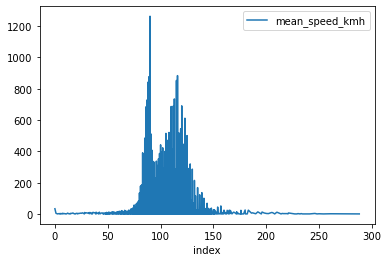

In [8]:
# Is the speed distribution coherent ?
sp = counting_loop_df.mean_speed_kmh
speed_distribution = pd.DataFrame(counting_loop_df['mean_speed_kmh'].value_counts())
speed_distribution.sort_index().reset_index().plot(x ='index', y=['mean_speed_kmh'], kind = 'line')

print(f'the mode of the distribution is {sp.mode()[0]} km/h (trucks?), the mean is {sp.mean()} km/h and the median {sp.median()} km/h')


In [9]:
# [counting_loop_df[column].value_counts() for column in counting_loop_df.columns] 

### ANPR

In [11]:
# check NaN values in anpr_df

na_count = [(column,anpr_df[column].isna().sum()) for column in anpr_df.columns]

na_count0 = [(column,anpr_df[anpr_df['count']==0][column].isna().sum()) for column in anpr_df.columns]

print(na_count)

print(na_count0)

anpr_df = anpr_df[anpr_df['count']!=0] # drop empty timeframes

# NaN values in rs and speedest only where count=0 --> it's consistent

[('B', 0), ('lane', 0), ('l', 0), ('timestamp', 0), ('rs', 70008), ('speedest', 70008), ('count', 0)]
[('B', 0), ('lane', 0), ('l', 0), ('timestamp', 0), ('rs', 70008), ('speedest', 70008), ('count', 0)]


In [12]:
# [anpr_df[column].value_counts() for column in anpr_df.columns]

# Many issues in the anpr dataset at first sight (even after removing null count) :

# ~8% of the lanes are undetected
# ~30% of the vehicles types are undected
# most of the radar speeds are nulls -> missdetection ? traffic jam ?
# most of the camera speeds are incoherents -> -1 , -2 , -1.288, 0, ...

In [38]:
# Let's first trim any entries with incoherents speeds
anpr_df = anpr_df[(anpr_df.speedest > 0) & (anpr_df.rs > 0)]

# Let's also remove the speeds outliers 
anpr_df = anpr_df[(anpr_df.speedest < 300) & (anpr_df.rs < 300)]

# 1) Count comparison 

First, we'll remove the fastest lane from the loop dataframe to match the anpr dataframe

Plot for lane 1, the mode of the distribution is 86.0 km/h, the mean is 98.7894152477034 km/h
Plot for lane 2, the mode of the distribution is 90.0 km/h, the mean is 112.59488165821136 km/h
Plot for lane 3, the mode of the distribution is 123.0 km/h, the mean is 123.6668818015429 km/h


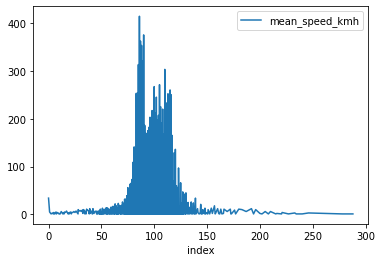

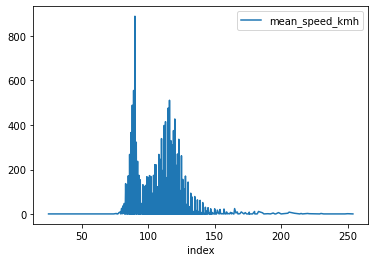

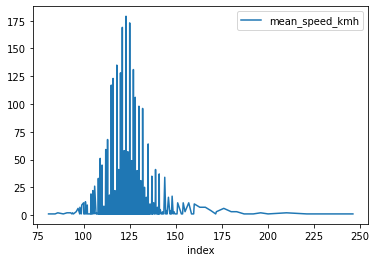

In [15]:
for lane in counting_loop_df.loop.unique():
    temp_df = counting_loop_df[counting_loop_df.loop == lane]
    sp = temp_df.mean_speed_kmh
    print(f'Plot for lane {lane}, the mode of the distribution is {sp.mode()[0]} km/h, the mean is {sp.mean()} km/h')
    speed_distribution = pd.DataFrame(temp_df['mean_speed_kmh'].value_counts())
    speed_distribution.sort_index().reset_index().plot(x ='index', y=['mean_speed_kmh'], kind = 'line')

The fastest lane is the third one

In [16]:
counting_loop_df = counting_loop_df[counting_loop_df.loop != 3]

We'll also trim counting_loop_df to match anpr_df timeframes

In [17]:
counting_loop_df = counting_loop_df[(counting_loop_df.timestamp >= "2021-10-04 13:25:00") & (counting_loop_df.timestamp <= "2021-10-31 16:30:00")]

Now we'll trim the ANPR dataframe to only keep the CPT-C-0002.1 camera

In [18]:
anpr_df = anpr_df[anpr_df.B == 'CPT-C-0002.1']

Now we build a function to effectively extract and compare the count values for selected days and time scale

<AxesSubplot:xlabel='timestamp'>

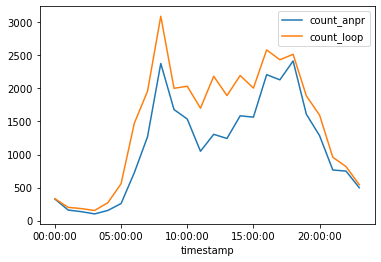

In [37]:
def get_count_df(anpr: pd.DataFrame, loop: pd.DataFrame, starting_time: str = "2021-10-04 13:25:00", end_time: str = "2021-10-31 16:30:00", days: list = None, date_collapse : bool = False, scale: str = None):
    # select entries from requested timeframes
    reduce_anpr = anpr[(anpr['timestamp'] > starting_time) & (anpr['timestamp'] <= end_time)]
    # collapse entries on the count values and sum
    anpr_ = pd.DataFrame(reduce_anpr.groupby('timestamp')['count'].sum())
    
    reduce_loop = loop[(loop['timestamp'] > starting_time) & (loop['timestamp'] <= end_time)]
    loop_ = pd.DataFrame(reduce_loop.groupby('timestamp')['count'].sum())
    
    # merge the results
    comparison = anpr_.merge(loop_, on='timestamp', suffixes=['_anpr','_loop']).reset_index()
    
    if days is not None:
        # if needed, select relevant days of the weeks
        comparison = comparison[comparison['timestamp'].dt.day_name().isin(days)]
    
    if scale is not None:
        # if needed, rescale the timestamps and groupby again
        comparison['timestamp'] = comparison['timestamp'].dt.round(scale)
        comparison = comparison.groupby('timestamp')['count_anpr','count_loop'].sum().reset_index()
    
    if date_collapse:
        # if True, will regroup entries by the time of the day (for all the dates)
        comparison['timestamp'] = comparison['timestamp'].dt.strftime('%H:%M:%S')
        comparison = comparison.groupby('timestamp')['count_anpr','count_loop'].mean().reset_index()
        
    return comparison

# examples :

# return a dataframe comparing the counts the day of the 12th of October, rescaled on every 2 hours
get_count_df(anpr_df, counting_loop_df, starting_time = "2021-10-12 00:00:00", end_time = "2021-10-13 00:00:00", scale = "2H")

# return a dataframe comparing the counts for all satarudays and sundays, rescaled on every 15 minutes
get_count_df(anpr_df, counting_loop_df, days = ['Saturday','Sunday'], scale = "15T")

# plot the comparison between anpr and loop counts for all days of the week (collapsed), rescaled on every hour
day_of_week = ['Monday','Tuesday','Wednesday','Thursday','Friday']
get_count_df(anpr_df, counting_loop_df, days = day_of_week, date_collapse = True, scale = "H").plot(x ='timestamp', y=['count_anpr','count_loop'], kind = 'line')